<img src="../img/logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales
# Semana 6:
#### Nicolás Pereyra
---

## Consigna:

En esta tarea continuaremos con el capítulo 14 de Holton. *DSP Principles and Applications*.

Comenzaremos con la generación de la siguiente señal:

$x(k) = a_0 \cdot \sin(\Omega_1 \cdot k) + n_a(k)$

siendo:  
- \( $a_0 = 2$ \)  
- \( $\Omega_1 = \Omega_0 + f_r \cdot \frac{2\pi}{N}$ \)  
- \( $\Omega_0 = \frac{\pi}{2}$ \)  

siendo la variable aleatoria definida por la siguiente distribución de probabilidad:  
- \( $f_r \sim U(-2, 2)$ \)  
- \( $n_a \sim \mathcal{N}(0, \sigma^2)$ \)  

Diseñe los siguientes estimadores de amplitud \( $a_1$ \):

$\hat{a}_1^i = |X_w^i(\Omega_0)| = \left| \mathcal{F}\{x(n) \cdot w_i(n)\} \right|$

y de frecuencia \( $\Omega_1$ \):

$\hat{\Omega}_1^i = \arg\max \left\{ |X_w^i(\Omega)| \right\}$

Para cada una de las siguientes ventanas:
- Rectangular (sin ventana)
- FlatTop  
- Blackman-Harris  
- Otra a elección de `scipy.signal.windows`

---

### Experimentación

Considere 200 realizaciones (muestras tomadas de \( $f_r$ \)) de 1000 muestras para cada experimento.  
Parametrice para SNRs de 3 dB y 10 dB.  
**Ayuda**: calibre \( $a_1$ \) para que la potencia de la senoidal sea 1 W.

---

### Se pide:

1) Realizar una tabla por cada SNR que describa el sesgo y la varianza de cada estimador, para cada ventana analizada.  
   Se debe estimar la varianza en la **amplitud** y en la **frecuencia**.

---

#### Ayuda:

Se puede calcular experimentalmente el sesgo y la varianza de un estimador. Para la amplitud:

$\hat{a}_0 = |X_w^i(\Omega_0)|$

Entonces:

- Sesgo:  
  $s_a = \mathbb{E}[\hat{a}_0] - a_0$

- Varianza:  
  $v_a = \text{Var}[\hat{a}_0] = \mathbb{E}[(\hat{a}_0 - \mathbb{E}[\hat{a}_0])^2]$

Y estas se pueden aproximar experimentalmente como:

- Media muestral:  
  $\mu_{\hat{a}} = \frac{1}{M} \sum_{j=0}^{M-1} \hat{a}_j$

- Sesgo:  
  $s_a = \mu_{\hat{a}} - a_0$

- Varianza:  
  $v_a = \frac{1}{M} \sum_{j=0}^{M-1} (\hat{a}_j - \mu_{\hat{a}})^2$

---

#### Bonus

💎 Analice el efecto del *zero-padding* sobre el estimador \( $\hat{\Omega}_1$ \)

🤯 Proponga estimadores alternativos para frecuencia y amplitud de la senoidal y repita el experimento.


In [5]:
from IPython.display import display

# --- Visualización elegante en Jupyter Notebook ---
def mostrar_tabla_estilizada(tabla, titulo=""):
    return tabla.style.set_caption(titulo)\
                      .format(precision=4)\
                      .set_table_styles([
                          {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '1.2em'), ('font-weight', 'bold')]}
                      ])
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows
from scipy.fft import fft, fftfreq
import pandas as pd

# --- Configuración general ---
np.random.seed(0)
M = 200          # Cantidad de realizaciones
N = 1000         # Muestras por realización
a0 = 2           # Amplitud real antes de normalizar
Omega_0 = np.pi/2

# --- Ventanas a evaluar ---
ventanas = {
    'Rectangular': np.ones(N),
    'Flat-top': windows.flattop(N),
    'Blackman': windows.blackman(N),
    'Hann': windows.hann(N),  # Otra ventana a elección
}

# --- Función de generación y estimación ---
def estimar(SNR_dB):
    results = {}
    for nombre, w in ventanas.items():
        a_estimates = []
        f_estimates = []

        for _ in range(M):
            # Aleatoriedad de la frecuencia (uniforme)
            fr = np.random.uniform(-2, 2)
            Omega_1 = Omega_0 + fr * 2 * np.pi / N

            # Señal pura (sin ruido)
            x_clean = a0 * np.sin(Omega_1 * np.arange(N))

            # Normalización: la potencia de la señal senoidal debe ser 1 W
            potencia_senial = np.mean(x_clean**2)
            x_clean /= np.sqrt(potencia_senial)  # Normalizamos a 1 W

            # Cálculo de la potencia de ruido para lograr el SNR requerido
            SNR_linear = 10**(SNR_dB / 10)
            sigma2 = 1 / SNR_linear  # Porque P_signal = 1
            ruido = np.random.normal(0, np.sqrt(sigma2), size=N)

            # Señal total
            x = x_clean + ruido

            # Aplicación de ventana
            x_win = x * w
            X = fft(x_win, n=N)
            freqs = fftfreq(N, d=1) * 2 * np.pi

            # Estimación de amplitud en Omega_0
            idx = np.argmin(np.abs(freqs - Omega_0))
            a_hat = np.abs(X[idx]) / np.sum(w)

            # Estimación de frecuencia
            idx_freq = np.argmax(np.abs(X))
            Omega_hat = freqs[idx_freq]

            a_estimates.append(a_hat)
            f_estimates.append(Omega_hat)

        # Calculo de sesgo y varianza
        mu_a = np.mean(a_estimates)
        sesgo_a = mu_a - 1  # Porque normalizamos la amplitud a 1
        varianza_a = np.var(a_estimates)

        mu_f = np.mean(f_estimates)
        sesgo_f = mu_f - Omega_1
        varianza_f = np.var(f_estimates)

        results[nombre] = {
            's_a': sesgo_a,
            'v_a': varianza_a,
            's_f': sesgo_f,
            'v_f': varianza_f
        }
    return results

# --- Ejecución ---
res_3dB = estimar(SNR_dB=3)
res_10dB = estimar(SNR_dB=10)

# --- Visualización en tablas ---
def formatear_resultados(resultados):
    tabla_a = pd.DataFrame({k: {'$s_a [V]]$': v['s_a'], '$v_a [V²]$': v['v_a']} for k, v in resultados.items()}).T
    tabla_f = pd.DataFrame({k: {'$s_\Omega$ [V]': v['s_f'], '$v_\Omega$ [V²]': v['v_f']} for k, v in resultados.items()}).T
    return tabla_a, tabla_f

tabla_a_3dB, tabla_f_3dB = formatear_resultados(res_3dB)
tabla_a_10dB, tabla_f_10dB = formatear_resultados(res_10dB)

# Mostrar todas las tablas con display()
display(mostrar_tabla_estilizada(tabla_a_3dB, "Estimación de Amplitud (SNR = 3 dB)"))
display(mostrar_tabla_estilizada(tabla_f_3dB, "Estimación de Frecuencia (SNR = 3 dB)"))

display(mostrar_tabla_estilizada(tabla_a_10dB, "Estimación de Amplitud (SNR = 10 dB)"))
display(mostrar_tabla_estilizada(tabla_f_10dB, "Estimación de Frecuencia (SNR = 10 dB)"))

# --- Obtener estimaciones individuales para SNR = 3dB ---
estimaciones_amp_3dB = []
estimaciones_freq_3dB = []

for nombre, w in ventanas.items():
    a_estimates = []
    f_estimates = []

    for _ in range(M):
        fr = np.random.uniform(-2, 2)
        Omega_1 = Omega_0 + fr * 2 * np.pi / N

        x_clean = a0 * np.sin(Omega_1 * np.arange(N))
        x_clean /= np.sqrt(np.mean(x_clean**2))

        SNR_linear = 10**(3 / 10)
        sigma2 = 1 / SNR_linear
        ruido = np.random.normal(0, np.sqrt(sigma2), size=N)

        x = x_clean + ruido
        x_win = x * w
        X = fft(x_win, n=N)
        freqs = fftfreq(N, d=1) * 2 * np.pi

        idx = np.argmin(np.abs(freqs - Omega_0))
        a_hat = np.abs(X[idx]) / np.sum(w)
        idx_freq = np.argmax(np.abs(X))
        Omega_hat = freqs[idx_freq]

        a_estimates.append(a_hat)
        f_estimates.append(Omega_hat)

    estimaciones_amp_3dB.append(a_estimates)
    estimaciones_freq_3dB.append(f_estimates)



,$s_a [V]]$,$v_a [V²]$
Rectangular,-0.7214,0.0509
Flat-top,-0.3547,0.0067
Blackman,-0.5951,0.0446
Hann,-0.6490,0.0557


,$s_\Omega$ [V],$v_\Omega$ [V²]
Rectangular,-0.0091,0.0001
Flat-top,-0.0021,0.0001
Blackman,-0.0081,0.0001
Hann,-0.0003,0.0001


,$s_a [V]]$,$v_a [V²]$
Rectangular,-0.7366,0.0526
Flat-top,-0.3612,0.0065
Blackman,-0.5946,0.0454
Hann,-0.6479,0.0538


,$s_\Omega$ [V],$v_\Omega$ [V²]
Rectangular,-0.0071,0.0001
Flat-top,-0.0012,0.0001
Blackman,0.0087,0.0001
Hann,0.0095,0.0001


### Análisis de resultados

Con estas tablas de datos, debemos detenernos a analizar cuál es el significado real de los valores obtenidos. Para entender estos resultados, es importante comprender el significado estadístico del **sesgo** ($s_a$) y la **varianza** ($v_a$).

El **sesgo** representa cuán lejos está nuestra estimación del valor esperado. En este caso, como trabajamos con una señal continua, evaluamos el promedio del sesgo a lo largo del tiempo de medición. En otras palabras, estamos midiendo un **error sistemático**. Por otro lado, la **varianza** cuantifica la dispersión de los valores estimados, es decir, cómo varían respecto al valor medio. Esto representa el **ruido aleatorio** del estimador.

Con estos conceptos claros, realizaremos un análisis paso a paso evaluando cada conjunto de datos.

---

#### Estimación de Amplitud

Comenzamos el análisis observando los resultados de estimación de amplitud. A continuación, se presenta un "ranking" para cada métrica (sesgo y varianza) según el desempeño de las distintas ventanas. Cuanto más cercanos a cero sean tanto el sesgo como la varianza, mejor será el rendimiento de la ventana.

##### Caso SNR = 3 dB y 10 dB

- **Sesgo**:
    1) Flat-top  
    2) Blackman  
    3) Hann  
    4) Rectangular  

- **Varianza**:
    1) Flat-top  
    2) Blackman  
    3) Rectangular  
    4) Hann  

Como se observa en este análisis, midiendo únicamente una señal sinusoidal, la ventana con mejor rendimiento general es **Flat-top**, mientras que las de peor desempeño son **Hann** y **Rectangular**, dependiendo de si se prioriza menor sesgo o menor varianza. Típicamente se considera más importante una **menor varianza**, ya que los sesgos (errores sistemáticos) pueden ser corregidos mediante calibraciones, mientras que la varianza (error aleatorio) no.

Dejando de lado el comportamiento general, observamos cómo varía la respuesta de cada ventana al modificar el **SNR**. Al aumentar el SNR, estamos disminuyendo el nivel de ruido, por lo que deberíamos esperar una disminución tanto en el módulo del sesgo como en la varianza.

Sin embargo, esto **no ocurre de manera uniforme**. Por ejemplo:
- El sesgo disminuye al usar ventanas **Blackman** y **Hann**.
- La varianza mejora con **Hann** y **Rectangular**.
- En cambio, las ventanas no mencionadas en cada caso presentan un **empeoramiento** al aumentar el SNR.

Esto puede parecer contradictorio, pero es lógico si consideramos cómo cada ventana modifica el espectro: al reducir el ruido, se revela con mayor claridad el **sesgo estructural** introducido por la ventana.

En base a este análisis, podemos concluir que la mejor ventana para medir señales sinusoidales en este contexto es **Blackman**, ya que ofrece el segundo mejor desempeño general y una evolución más coherente al aumentar el SNR.

---

#### Estimación de Frecuencia

Realizamos nuevamente un ranking del desempeño para las distintas ventanas, ahora en la estimación de frecuencia.

##### Caso SNR = 3 dB

- **Sesgo**:
    1) Hann  
    2) Flat-top  
    3) Blackman  
    4) Rectangular  

- **Varianza**:
    1) Rectangular  
    2) Blackman  
    3) Hann  
    4) Flat-top  

##### Caso SNR = 10 dB

- **Sesgo**:
    1) Flat-top  
    2) Rectangular  
    3) Blackman  
    4) Hann  

- **Varianza**:
    1) Hann  
    2) Blackman  
    3) Flat-top  
    4) Rectangular  

Como se puede observar, los rankings para 3 dB y 10 dB no coinciden, principalmente debido a la **baja dispersión** en los datos de este caso: la varianza es prácticamente la misma en todas las ventanas, por lo que **el sesgo se vuelve más determinante**.

También se observa un comportamiento peculiar: las ventanas **Blackman** y **Hann** pasan de **infraestimar a sobreestimar** la frecuencia al aumentar el SNR, lo cual sugiere un **sesgo no lineal** influenciado por el nivel de ruido.

De forma similar al análisis de amplitud, observamos nuevamente **un aumento del sesgo y/o la varianza al mejorar el SNR** en ciertos casos. Esto refuerza la idea de que el ruido ocultaba errores sistemáticos que se revelan cuando este disminuye.

---

## Histograma:

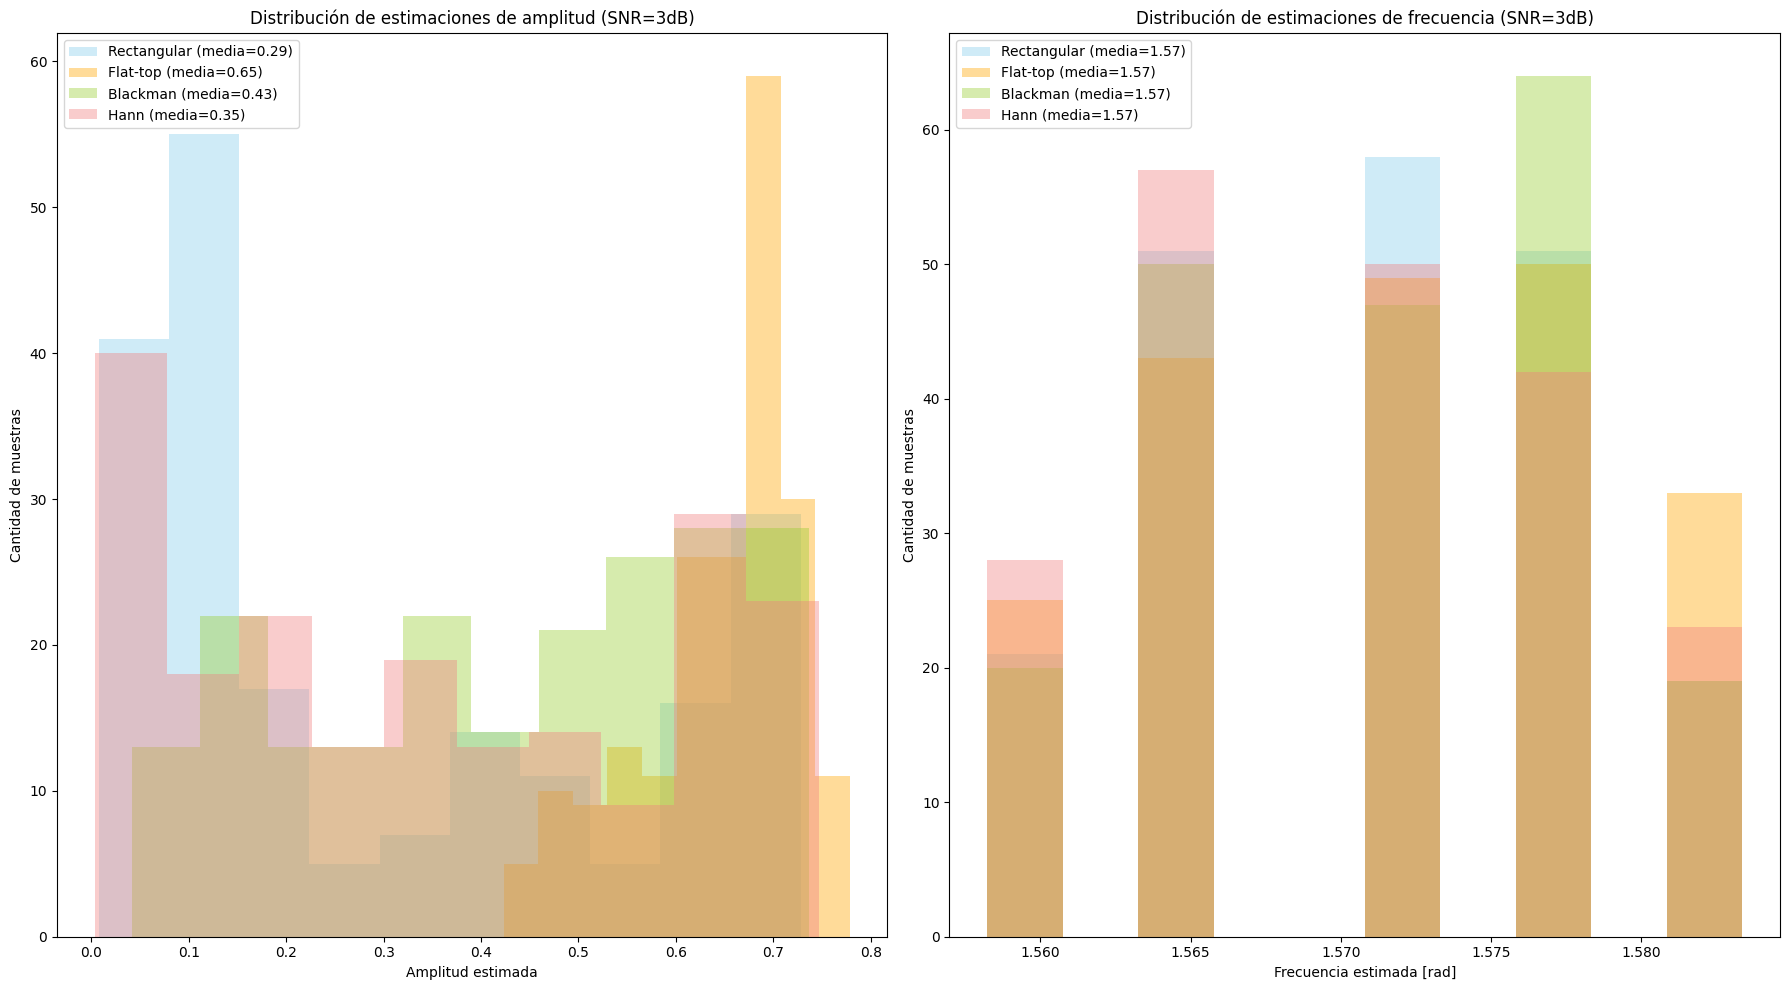

In [21]:
# --- Histograma de estimaciones para SNR = 3dB ---
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))
colores = ['skyblue', 'orange', 'yellowgreen', 'lightcoral']
ventanas_nombres = list(ventanas.keys())

for i, nombre in enumerate(ventanas_nombres):
    mu_amp = np.mean(estimaciones_amp_3dB[i])
    mu_freq = np.mean(estimaciones_freq_3dB[i])

    plt.subplot(1, 2, 1)
    plt.hist(estimaciones_amp_3dB[i], bins=10, alpha=0.4, color=colores[i], label=f"{nombre} (media={mu_amp:.2f})")
    plt.title("Distribución de estimaciones de amplitud (SNR=3dB)")
    plt.xlabel("Amplitud estimada")
    plt.ylabel("Cantidad de muestras")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(estimaciones_freq_3dB[i], bins=10, alpha=0.4, color=colores[i], label=f"{nombre} (media={mu_freq:.2f})")
    plt.title("Distribución de estimaciones de frecuencia (SNR=3dB)")
    plt.xlabel("Frecuencia estimada [rad]")
    plt.ylabel("Cantidad de muestras")
    plt.legend()

plt.tight_layout()
plt.show()


---

## Grafico de las ventanas utilizando Zero-padding:
Utilizando el metodo de Zero-Padding analizaremos el comportamiento de cada ventana utilizada: 

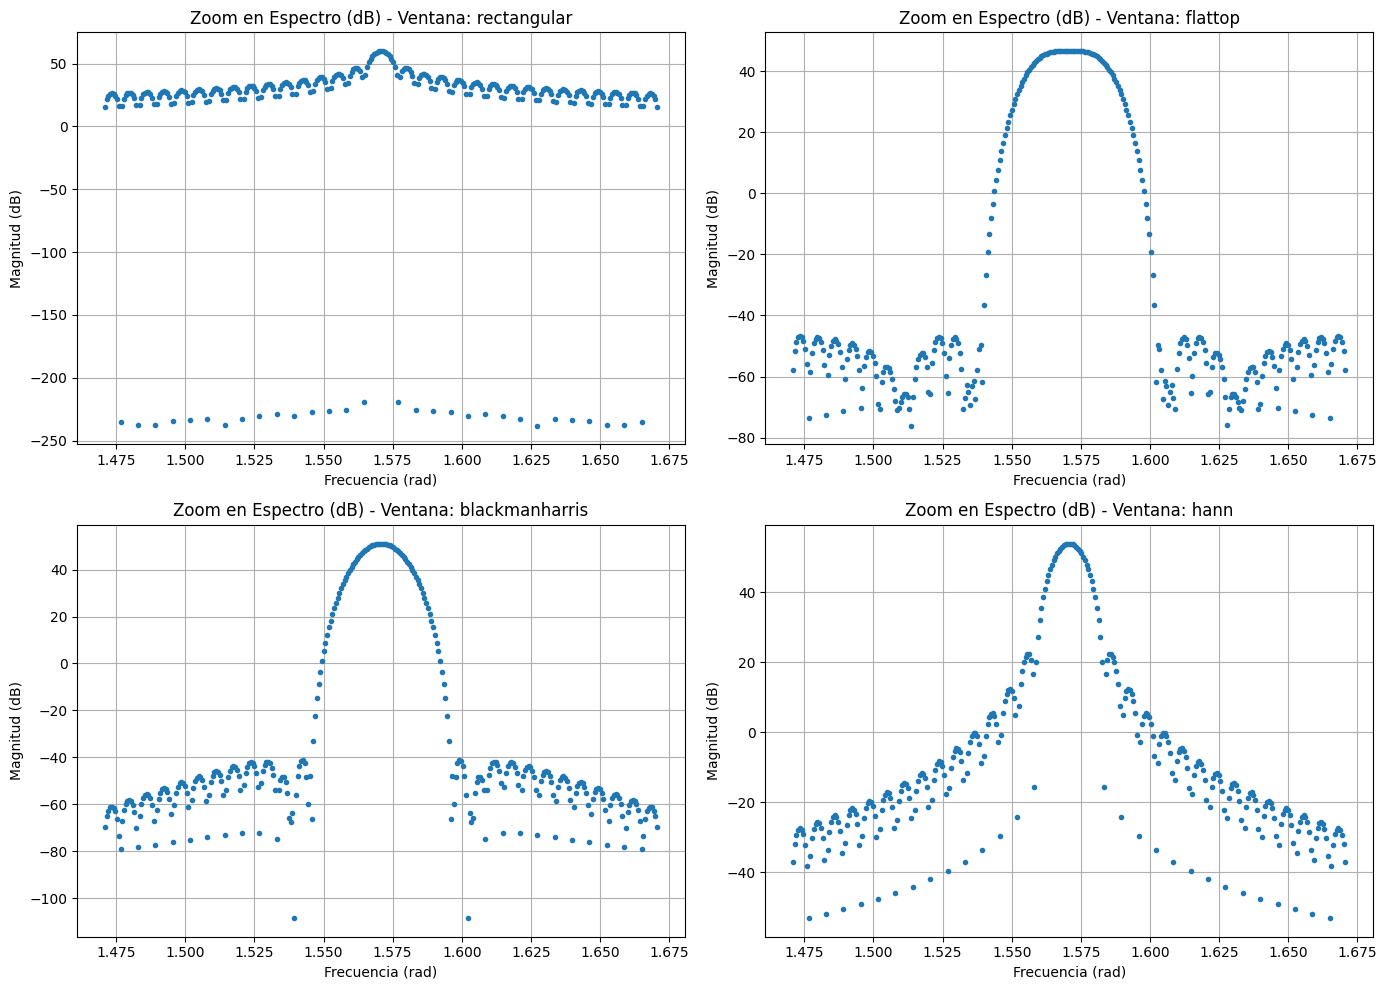

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import scipy.signal.windows as win

# Parámetros generales
N = 1000
N_pad = 10 * N  # Zero-padding

a0 = 2
Omega_0 = np.pi / 2
fr = 0
Omega_1 = Omega_0 + fr * (2 * np.pi / N)

k = np.arange(N)
x = a0 * np.sin(Omega_1 * k)

windows = {
    'rectangular': np.ones(N),
    'flattop': win.flattop(N),
    'blackmanharris': win.blackmanharris(N),
    'hann': win.hann(N)
}

plt.figure(figsize=(14, 10))

for i, (wname, w) in enumerate(windows.items(), 1):
    xw = x * w
    xw_padded = np.concatenate([xw, np.zeros(N_pad - N)])

    X = fft(xw_padded)
    freqs = fftfreq(N_pad, 1) * 2 * np.pi

    X_mag_db = 20 * np.log10(np.abs(X[:N_pad // 2]) + 1e-12)
    freqs = freqs[:N_pad // 2]

    # Zoom: entorno de Omega_1 ± 0.1 rad
    mask = (freqs > Omega_1 - 0.1) & (freqs < Omega_1 + 0.1)

    plt.subplot(2, 2, i)
    plt.plot(freqs[mask], X_mag_db[mask], marker='o', linestyle='None', markersize=3)
    plt.title(f"Zoom en Espectro (dB) - Ventana: {wname}")
    plt.xlabel("Frecuencia (rad)")
    plt.ylabel("Magnitud (dB)")
    plt.grid(True)

plt.tight_layout()
plt.show()


### Concluciones:
<img src="../img/holton_ventanas.png" /> 

Al aplicar una ventana a una señal antes de transformarla con la FFT, se busca reducir el efecto del leakage (fugas espectrales) que ocurre cuando la señal no es perfectamente periódica dentro del marco de observación. A continuación, se describen las caractenisticas mas imporntantes de cada una, es importante saber que como todo en la ingenieria nos encontramos en un problema de sabana corta debido a que si queremos mejorar el ancho de banda tendremos que disminiuir la distancia entre el maximo y el maximo del primer lobulo. Debido a esto hay diferentes tipos de ventanas las cuales nos permiten elegir extremos (como la Rectangular o la Clack Blackman) o situaciones mas intermedias como Hann y Hamming.

### 1. Rectangular:
+ No se coloca ninguna ventana.
+ Ancho de banda de $\Delta \omega=\frac{4\pi}{N}$
+ $-13dB$ entre el maximo y el primer lobulo.
+ Caída de lóbulos: Lenta (-6 dB/oct).

### 2. Hamming:
+ Ancho de banda de $\Delta \omega=\frac{8\pi}{N}$
+ $-43dB$ entre el maximo y el primer lobulo
+ Caída: Lenta (-6 dB/oct).

### 3. Hann:
+ Ancho de banda de $\Delta \omega=\frac{8\pi}{N}$
+ $-32dB$ entre el maximo y el primer lobulo
+ Caída: Rápida (-18 dB/oct).

### 4. Blackman:
+ Ancho de banda de $\Delta \omega=\frac{12\pi}{N}$
+ $-58dB$ entre el maximo y el primer lobulo
+ Caída: Rápida (-18 dB/oct).

### 4. FlatTop:
+ Ancho de banda de $\Delta \omega=\frac{12\pi}{N}$
+ $-93dB$ entre el maximo y el primer lobulo
+ Caída: Rápida (-18 dB/oct).


